In [1]:
# Run this line below into the console while in the directory of where the images will be saved.

# ffmpeg -start_number 0 -framerate 60 -i graph%01d.png video.webm

In this notebook we want to lookd a few different numerical wave phenomenon. I just think waves are cool and PDEs are some of my favorite structures in all of mathematics. That being said, I ultimately want to make some wave simulations under a few different constraints. My big goals are as follows:
- Create a basic 2D wave progpogation simulation
- Create a similar sort of equation for Schrodinger equation
- Create a 3D wave simulation

In [11]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import os
import sys
from matplotlib import cm
from matplotlib.animation import FuncAnimation
import matplotlib as mpl
from tqdm import tqdm

In [3]:
#We have this cell here to call the dataAnalysisLibrary module from one place rather than copy pasting into many other places
# the ../ means one directory back, which is, so this should fix pathing problems moving forward

sys.path.insert(0,'../Code/')
import simulationLibrary as sim

In [4]:
sim.clearDirectory()

# Introduction

I have scowered far and wide for a good guide for this project and have come up with nothing. Sure, I have found some resources here and there than give insight into pieces of this puzzle but never the whole picture. I aim to change that with this notebook. This will be split in to two(ish) main parts. The first part being the mathematical derivation of our numerical scheme, or in otherworse how to turn a PDE into something a computer can handle. The second part will be the implementation of said numerical scheme into a coding language, in our case python. In this second section I want to make a clear translation between the mathematics and the code, and so that anyone could read this article and translate the concepts into whatever other coding language they see fit. After the second section I will also provide similar but more condensed derivations of other forms of the wave equation and their implementations, like the damped/forced wave quation and their higher dimensional counterparts.

# Part One: The Derivation
The good ol general wave equation is as follows:

$$
\begin{center}
    \frac{\partial^2 u}{\partial t^2}=c^2 \nabla u
\end{center}
$$

In [7]:
def func(x):
    return(x*((2*np.pi)-x))

In [8]:
def gaussianDistribution(x, mean, std_dev):
    coefficient = 1 / (std_dev * np.sqrt(2 * np.pi))
    exponent = -((x - mean) ** 2) / (2 * std_dev ** 2)
    return(coefficient * np.exp(exponent))

# Traditional Wave Equation

In [43]:
def waveSimulation(initialFunc, c=1, length=1, totalTime=5, Nx=200, Nt=1000):
    # Lets create a meshed function
    length = length
    c=c
    totalTime = totalTime
    Nx = Nx # x axis
    Nt = Nt # t axis
    deltax = length/(Nx-1) # THIS IS THE IMPORTANT LINE OR ELSE IT BLOWS UP!!!!!!!!!!!!!!!!!!!! I HAVE NO CLUE WHY THAT -1 NEEDS TO BE THERE BUT IT DOES OR EVERYTHING GOES TO SHIT
    deltat = totalTime/Nt
    C=c*(deltat/deltax)
    if C >=1 :
        print("C is greater than 1. C="+str(C))
        sys.exit(1)
    
    x=np.linspace(0,length,Nx)
    t=np.linspace(0,totalTime, Nt)
    
    u=np.zeros((Nt, Nx))
    u[0]=initialFunc(x)
    u[1]=u[0]
    for n in tqdm(range(1,Nt-1)):
        for i in range(1,Nx-1): # All interior points
            u[n+1,i]=(2 * (1 - C**2) * u[n, i] - u[n - 1, i] + C**2 * (u[n, i + 1] + u[n, i - 1]))

    sim.clearDirectory()
    for i in tqdm(range(Nt)):
        plt.plot(u[i])
        plt.xlim(0,Nx)
        plt.ylim(-5,5)
        plt.savefig('../..//Physics-Simulations/Images for simulation/graph'+str(i)+'.png') # dpi argument increases resolution
        plt.close('all')

In [49]:
sim.clearDirectory()

# Damped Wave Equation

In [4]:
def gaussianDistribution(x, mean=0.5, std_dev=0.1):
    coefficient = 1 / (std_dev * np.sqrt(2 * np.pi))
    exponent = -((x - mean) ** 2) / (2 * std_dev ** 2)
    return(coefficient * np.exp(exponent))

In [9]:
def dampedWaveSimulation(initialFunc, c=1, gamma=1, length=1, totalTime=5, Nx=200, Nt=1000):
    # Lets create a meshed function
    length = length
    c=c
    gamma = gamma
    totalTime = totalTime
    Nx = Nx # x axis
    Nt = Nt # t axis
    deltax = length/(Nx-1) # THIS IS THE IMPORTANT LINE OR ELSE IT BLOWS UP!!!!!!!!!!!!!!!!!!!! I HAVE NO CLUE WHY THAT -1 NEEDS TO BE THERE BUT IT DOES OR EVERYTHING GOES TO SHIT
    deltat = totalTime/Nt
    C=c*(deltat/deltax)
    if C >=1 :
        print("C is greater than 1. C="+str(C))
        sys.exit(1)
    
    x=np.linspace(0,length,Nx)
    t=np.linspace(0,totalTime, Nt)

    # sigma = 1
    # u_initial = np.exp(-((x - 0.1)**2) / (2 * sigma**2))
    # v_initial = (A * v * (x - x_0) / sigma**2) * np.exp(-((x - x_0)**2) / (2 * sigma**2))
    
    u=np.zeros((Nt, Nx))
    u[0]=initialFunc(x)
    u[1]=u[0]
    for n in tqdm(range(1,Nt-1)):
        for i in range(1,Nx-1): # All interior points
            u[n+1,i]=(1/(1+gamma*deltat))*((2*u[n, i]*(1-gamma*deltat))-(u[n-1,i]*(1-gamma*deltat))+(C**2)*(u[n,i+1]-2*u[n,i]+u[n,i-1]))
            
    sim.clearDirectory()
    for i in tqdm(range(Nt)):
        plt.plot(u[i])
        plt.xlim(0,Nx)
        plt.ylim(-5,5)
        plt.savefig('../..//Physics-Simulations/Images for simulation/graph'+str(i)+'.png', dpi=300) # dpi argument increases resolution
        plt.close('all')

 13%|█████████▊                                                                   | 128/1000 [01:05<07:28,  1.95it/s]


KeyboardInterrupt: 

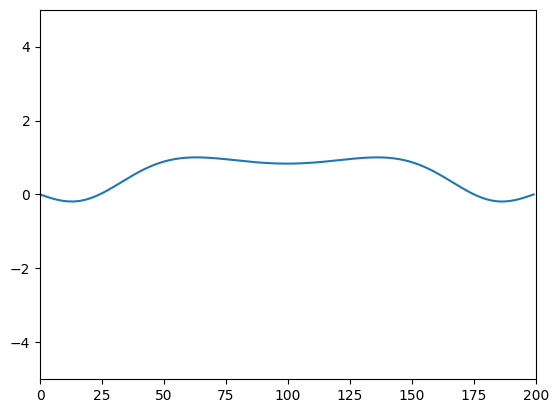

In [10]:
dampedWaveSimulation(gaussianDistribution)

In [50]:
sim.clearDirectory()

# Two dimensional wave equation

In [13]:
def initialMultiVarFunc(x,y):
    return(np.sin(np.pi * np.outer(np.sin(np.pi * x), np.sin(np.pi * y))))

  0%|                                                                                         | 0/98 [00:00<?, ?it/s]C:\Users\darkb\AppData\Local\Temp\ipykernel_17384\1692135518.py:32: RuntimeWarning: overflow encountered in divide
  (u[n, 2:, 1:-1] - 2 * u[n, 1:-1, 1:-1] + u[n, :-2, 1:-1]) / deltax**2 +
C:\Users\darkb\AppData\Local\Temp\ipykernel_17384\1692135518.py:33: RuntimeWarning: overflow encountered in divide
  (u[n, 1:-1, 2:] - 2 * u[n, 1:-1, 1:-1] + u[n, 1:-1, :-2]) / deltay**2
C:\Users\darkb\AppData\Local\Temp\ipykernel_17384\1692135518.py:32: RuntimeWarning: overflow encountered in add
  (u[n, 2:, 1:-1] - 2 * u[n, 1:-1, 1:-1] + u[n, :-2, 1:-1]) / deltax**2 +
C:\Users\darkb\AppData\Local\Temp\ipykernel_17384\1692135518.py:32: RuntimeWarning: overflow encountered in subtract
  (u[n, 2:, 1:-1] - 2 * u[n, 1:-1, 1:-1] + u[n, :-2, 1:-1]) / deltax**2 +
C:\Users\darkb\AppData\Local\Temp\ipykernel_17384\1692135518.py:33: RuntimeWarning: overflow encountered in subtract
  (u[n, 1:-1,

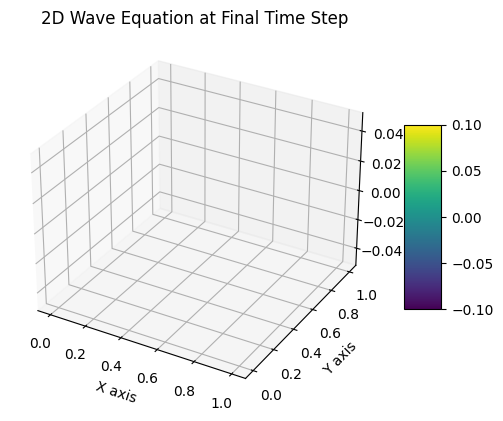

In [16]:
lengthx = 1
lengthy = 1
c = 1
totalTime = 1
Nx = 100 # x axis
Ny = 100 # y axis
Nt = 100 # t axis
deltax = lengthx/(Nx-1) # THIS IS THE IMPORTANT LINE OR ELSE IT BLOWS UP!!!!!!!!!!!!!!!!!!!! I HAVE NO CLUE WHY THAT -1 NEEDS TO BE THERE BUT IT DOES OR EVERYTHING GOES TO SHIT
deltay = lengthy/(Ny-1)
deltat = totalTime/Nt
C = c*(deltat/np.sqrt(deltax**2+deltay**2))
if C >= 1 :
    print("C is greater than 1. C="+str(C))
    sys.exit(1)

x = np.linspace(0, lengthx, Nx)
y = np.linspace(0, lengthy, Ny) 
t=np.linspace(0, totalTime, Nt)

f = initialMultiVarFunc(x,y)

u=np.zeros((Nt, Nx, Ny))
g = np.zeros((Nx, Ny)) # Initial Velocty (?)
u[0,:,:]=f
u[1, 1:-1, 1:-1] = f[1:-1, 1:-1] + deltat * g[1:-1, 1:-1] + (C**2 / 2) * (
    (f[2:, 1:-1] - 2 * f[1:-1, 1:-1] + f[:-2, 1:-1]) / deltax**2 +
    (f[1:-1, 2:] - 2 * f[1:-1, 1:-1] + f[1:-1, :-2]) / deltay**2
)

for n in tqdm(range(1, Nt - 1)):
    u[n + 1, 1:-1, 1:-1] = 2 * (1 - C**2) * u[n, 1:-1, 1:-1] - u[n - 1, 1:-1, 1:-1] + C**2 * (
        (u[n, 2:, 1:-1] - 2 * u[n, 1:-1, 1:-1] + u[n, :-2, 1:-1]) / deltax**2 +
        (u[n, 1:-1, 2:] - 2 * u[n, 1:-1, 1:-1] + u[n, 1:-1, :-2]) / deltay**2
    )
    # Apply boundary conditions
    u[n + 1, 0, :] = 0
    u[n + 1, -1, :] = 0
    u[n + 1, :, 0] = 0
    u[n + 1, :, -1] = 0

# Plotting the result in 3D at the final time step
X, Y = np.meshgrid(x, y)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, u[-1, :, :], cmap='viridis')

ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Wave Amplitude')
ax.set_title('2D Wave Equation at Final Time Step')
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
plt.show()

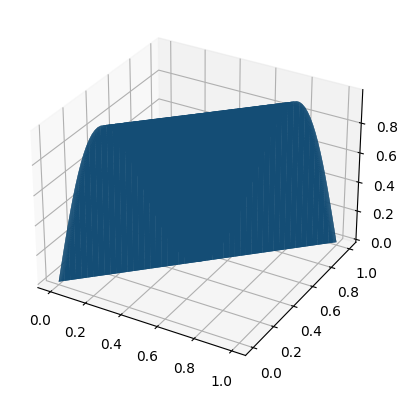

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(x, t, initialMultiVarFunc(x,y))

# One Dimensional Schrodinger Eq

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from tqdm import tqdm

# Constants
hbar = 1.0545718e-34  # Planck's constant divided by 2*pi
m = 9.10938356e-31    # Mass of the electron
L = 1e-8              # Length of the domain
Nx = 2000             # Number of spatial points
deltax = L / (Nx - 1) # Spatial step size
x = np.linspace(0, L, Nx)  # Spatial grid
deltat = 5*1e-19        # Time step size
totalTime = 1e-16     # Total time
Nt = int(totalTime / deltat)  # Number of time steps

# Correct constants
A = -1j * hbar * deltat / (2 * m * deltax**2)
B = 2j * deltat / hbar

V = np.zeros(Nx)

# Initial conditions: Gaussian wave packet
x0 = L / 2
k0 = 5e10
sigma = L / 20
psiReal = np.exp(- (x - x0)**2 / (2 * sigma**2)) * np.cos(k0 * x)
psiImag = np.exp(- (x - x0)**2 / (2 * sigma**2)) * np.sin(k0 * x)
psiInitial = psiReal + 1j * psiImag

# Initialize the wavefunction array
psi = np.zeros((Nt, Nx), dtype=complex)
psi[0, :] = psiInitial
psi[1, :] = psiInitial

# Time evolution
for n in tqdm(range(1, Nt - 1)):
    for j in range(1, Nx - 1):  # All interior points
        psi[n + 1, j] = A * (psi[n, j + 1] - 2 * psi[n, j] + psi[n, j - 1]) + psi[n - 1, j] - B * V[j] * psi[n, j]

    psi[n + 1, 0] = psi[n + 1, Nx - 1] = 0 #Enforce boundary conditions


100%|█████████████████████████████████████████████████████████████████████████| 197/197 [00:00<00:00, 712.20it/s]


In [12]:
sim.clearDirectory()
for i in tqdm(range(Nt)):
    plt.plot(np.real(psi[i]))
    plt.xlim(0,Nx)
    plt.ylim(-5,5)
    plt.savefig('../..//Physics-Simulations/Images for simulation/graph'+str(i)+'.png') # dpi argument increases resolution
    plt.close('all')

 53%|███████████████████████████████████████▍                                  | 106/199 [00:08<00:07, 11.99it/s]


KeyboardInterrupt: 